# 全连接神经网络


## 网络架构


在之前的课程（[课程2](../02_RéseauFullyConnected/README.md)）中，我们构建了用于分类问题的全连接神经网络。在此，我们将处理一个基于离散数据的预测问题。


### 模型灵感


本笔记本中的网络架构灵感来源于论文 ["A Neural Probabilistic Language Model"](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)。

该网络的架构如下图所示：

![Bengio](./images/bengio.png)

（图片来源于原论文）

在论文中，模型使用三个输入单词来预测下一个单词。在我们的案例中，我们将使用字符，类似于之前的笔记本。

**嵌入矩阵 $C$**：可以看到，网络包含一个矩阵 $C$，它将单词（或字符）编码到潜在空间中。这种做法在自然语言处理（NLP）中很常见，因为它能将相似的单词在潜在空间中聚集。例如，在大多数句子中，“狗”和“猫”可以互换，这意味着它们在潜在空间中的表示会比较接近，而“狗”和“是”则不会。

**网络的其余部分**：网络的其余部分更为经典。它以不同单词（或字符）的嵌入向量的拼接作为输入，并预测一个单词（或字符）作为输出。


该论文中的模型通过最小化*负对数似然*（与之前笔记本中使用双字模型的方法相同）进行训练。


### 我们的方法


在论文中，他们使用三个单词来预测第四个单词。我们将应用相同的原理，基于前三个字符来预测第四个字符。
论文中使用的潜在空间维度为30，用于包含17,000个不同单词的字典。由于我们只有46个字符，我们将任意选择嵌入维度为10。


## 网络实现


首先，我们重新构建来自[之前笔记本](../05_NLP/02_bigramme.ipynb)的 `stoi` 和 `itos` 列表：


Commençons par reconstruire nos listes stoi et itos du [notebook précédent](../05_NLP/02_bigramme.ipynb) :


In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, random_split
%matplotlib inline

In [2]:
words = open('prenoms.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

### 数据集与数据加载器的创建


构建我们的数据集，它与之前的数据集稍有不同，因为输入将是三个字符而不是一个。


In [3]:
block_size = 3 # La longueur du contexte, combien de caractères pour prédire le suivant ?
X, Y = [], []
for k,w in enumerate(words):
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    if (k<2): ## On affiche ce à quoi ressemble le dataset pour les deux premiers mots
      print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

... ---> M
..M ---> A
.MA ---> R
MAR ---> I
ARI ---> E
RIE ---> .
... ---> J
..J ---> E
.JE ---> A
JEA ---> N
EAN ---> .


In [4]:
X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.shape, X.dtype, Y.shape, Y.dtype)

torch.Size([226325, 3]) torch.int64 torch.Size([226325]) torch.int64


现在，我们将使用 PyTorch 构建训练集、验证集和测试集。


In [5]:
dataset=TensorDataset(X, Y)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(TensorDataset(X, Y),[train_size, val_size, test_size])
print("Taille du dataset de training : ",len(train_dataset))
print("Taille du dataset de validation : ",len(val_dataset))
print("Taille du dataset de test : ",len(test_dataset))

Taille du dataset de training :  181060
Taille du dataset de validation :  22632
Taille du dataset de test :  22633


我们还将创建数据加载器以进行小批量优化。


In [6]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

### 网络层


为了更好地理解我们构建的网络，我们不会使用 PyTorch 的 `nn.Linear()` 函数来创建层。
首先，我们将定义每层的神经元数量。


In [7]:
embed_dim=10 # Dimension de l'embedding de C
hidden_dim=200 # Dimension de la couche cachée

构建我们的嵌入矩阵 $C$（带可学习参数）。


In [8]:
C = torch.randn((46, embed_dim))
C[X].shape

torch.Size([226325, 3, 10])

通过调用 `C[X]`，借助 PyTorch 的索引功能（[链接](http://blog.ezyang.com/2019/05/pytorch-internals/)），我们可以得到 226,325 个样本中每三个字符的嵌入值。


现在，我们可以创建隐藏层 $W_1$ 和 $W_2$，以及它们的偏置 $b_1$ 和 $b_2$。


In [9]:
W1 = torch.randn((block_size*embed_dim, hidden_dim))
b1 = torch.randn(hidden_dim)
W2 = torch.randn((hidden_dim, 46))
b2 = torch.randn(46)
parameters = [C, W1, b1, W2, b2]
print("Nombre de paramètres du modèle : ",sum(p.nelement() for p in parameters))

Nombre de paramètres du modèle :  15906


为了训练这些层，我们需要启用 PyTorch 的 `requires_grad` 参数。这将指定我们希望为这些元素计算梯度。


In [10]:
for p in parameters:
  p.requires_grad = True

### 如何选择合适的学习率？


在训练神经网络时，选择学习率至关重要，但通常在没有预先测试的情况下很难确定合适的值。
选择学习率的一个有效方法是：
- 创建一个包含 -3 到 0 之间的 1000 个值的列表
- 对每个值取 $10^{valeur}$
这样，我们可以得到一个介于 $10^{-3} = 0.001$ 和 $10^{0} = 1$ 之间的值列表，这些值是学习率的潜在候选值。-3 和 0 的范围可以调整，您需要尝试找到包含最佳学习率的范围。


In [11]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

接下来，我们将根据学习率的不同值来跟踪训练集的损失值。


In [12]:
lri = []
lossi = []
count=0
while count<999:
  for x,y in train_loader:
    count+=1
    if count==999:
        break
    # forward pass
    emb = C[x]
    h = torch.tanh(emb.view(-1, block_size*embed_dim) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    
    # retropropagation
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Mise à jour des poids du modèle
    lr = lrs[count]
    for p in parameters:
        p.data += -lr * p.grad

    lri.append(lre[count])
    lossi.append(loss.log10().item())

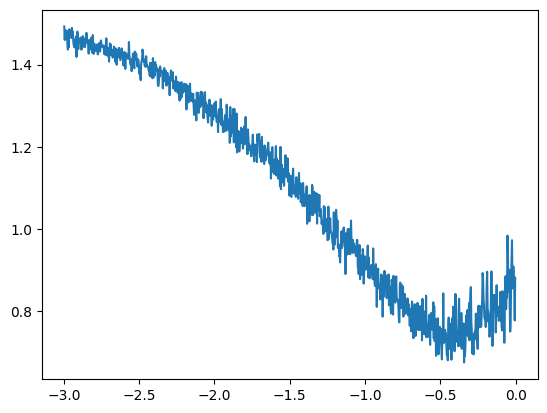

In [13]:
plt.plot(lri, lossi)

该曲线表明，合适的学习率在 $10^{-1}$ 和 $10^{-0.5}$ 之间。
因此，我们选择学习率为 0.2，并在训练过程中逐渐减小（这是一种常见的做法，有助于快速收敛并在训练后期进行精确优化）。


### 双曲正切函数


在我们的优化过程中，我们使用双曲正切函数作为激活函数。
其定义如下：
$\tanh(x) = \frac{\sinh(x)}{\cosh(x)} = \frac{e^x - e^{-x}}{e^x + e^{-x}}$
我们可以用 Python 来可视化它：


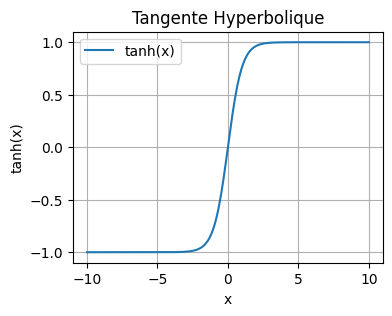

In [14]:
import numpy as np
x = np.linspace(-10, 10, 400)

y = np.tanh(x)

plt.figure(figsize=(4, 3))
plt.plot(x, y, label='tanh(x)')
plt.title('Tangente Hyperbolique')
plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.grid(True)
plt.legend()
plt.show()

通常，在我们的网络隐藏层中，我们更倾向于使用 *tanh* 函数而不是 *sigmoid* 函数，原因如下：
- 输出范围以零为中心（-1 到 1），有助于学习。
- 在 -2 到 2 之间的值，梯度比 sigmoid 函数更大。
- 这两点有助于减少[梯度消失问题](https://medium.com/@amanatulla1606/vanishing-gradient-problem-in-deep-learning-understanding-intuition-and-solutions-da90ef4ecb54)，并加快训练时的收敛速度。


### 网络优化


现在，我们进入网络优化阶段。首先定义我们的超参数：


In [15]:
lr=0.2
epochs=100

# Reinitialisons les paramètres pour plus de simplicité si on a besoin de relancer l'entraînement
C = torch.randn((46, embed_dim))
W1 = torch.randn((block_size*embed_dim, hidden_dim))
b1 = torch.randn(hidden_dim)
W2 = torch.randn((hidden_dim, 46))
b2 = torch.randn(46)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True


In [16]:
lossi=[]
lossvali=[]
stepi = []
for epoch in range(epochs):
  loss_epoch=0
  for x,y in train_loader:
    
    # forward pass
    emb = C[x]
    h = torch.tanh(emb.view(-1, block_size*embed_dim) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    
    # retropropagation
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Mise à jour des poids du modèle
    lr=lr if epoch<50 else lr*0.1
    for p in parameters:
        p.data += -lr * p.grad
    loss_epoch+=loss

  loss_epoch=loss_epoch/len(train_loader)
  stepi.append(epoch)
  lossi.append(loss_epoch.item())
  # Calcul du loss de validation (pour surveiller l'overfitting)
  loss_val=0
  for x,y in val_loader:
    emb = C[x]
    h = torch.tanh(emb.view(-1, block_size*embed_dim) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    loss_val+=loss
  loss_val=loss_val/len(val_loader)
  lossvali.append(loss_val.item())
  if epoch%10==0:
    print(f"Epoch {epoch} - Training loss: {loss_epoch.item():.3f}, Validation loss: {loss_val.item():.3f}")

Epoch 0 - Training loss: 5.273, Validation loss: 3.519
Epoch 10 - Training loss: 2.424, Validation loss: 2.594
Epoch 20 - Training loss: 2.337, Validation loss: 2.421
Epoch 30 - Training loss: 2.289, Validation loss: 2.468
Epoch 40 - Training loss: 2.259, Validation loss: 2.424
Epoch 50 - Training loss: 2.327, Validation loss: 2.372
Epoch 60 - Training loss: 2.326, Validation loss: 2.372
Epoch 70 - Training loss: 2.326, Validation loss: 2.372
Epoch 80 - Training loss: 2.326, Validation loss: 2.372
Epoch 90 - Training loss: 2.326, Validation loss: 2.372


绘制训练和验证的曲线。


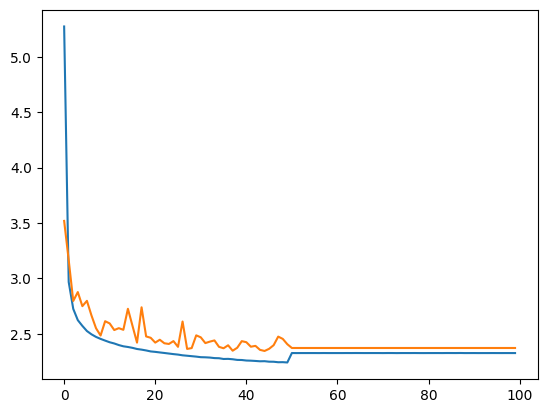

In [17]:
plt.plot(stepi, lossi)
plt.plot(stepi,lossvali)

### 模型测试


现在模型已经训练完成，我们将在测试数据上验证其性能。如果测试数据的损失与训练数据的损失相似，则说明模型训练良好。否则，可能存在过拟合（*overfitting*）问题。


In [18]:
# On annule le calcul des gradients car on n'est plus en phase d'entraînement.
for p in parameters:
  p.requires_grad = False
loss_test=0
for x,y in test_loader:
      
  # forward pass
  emb = C[x]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2 
  loss = F.cross_entropy(logits, y)

  loss_test+=loss
loss_test=loss_test/len(test_loader)
print(loss_test)

tensor(2.3505)


测试数据的似然值与训练数据的似然值较为接近，这表明训练过程进行得较为顺利。


我们观察到，本模型的*负对数似然*值低于之前笔记本中双字模型的值（$2.3 < 2.5$）。因此，生成的名字的质量应该会有所提高。


### 使用我们的模型生成名字


我们生成大约二十个名字，以评估生成质量。


In [19]:
for _ in range(20):
  out = []
  context = [0] * block_size 
  while True:
    emb = C[torch.tensor([context])] 
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  
  print(''.join(itos[i] for i in out))

JAÏMANT.
SONELIUWAN.
LYPHELSÏL.
DJELINATHEYMONDALYANE.
ERNANDRAN.
ESMALLOONIS.
ASHAMLANCHOND.
ANNAE.
CHALLA.
ETTE.
ASSANE.
MARIANE.
FIHAYLAY.
SHANA.
ALPHENELIESON.
ESÏL.
EVEY.
YSLALLYSSIA.
ETHELDOF.
KELLAH.


生成的名字仍然有些奇怪，但与双字模型生成的名字相比，它们已经更接近真实可能的名字。


**练习**：尝试修改各层的神经元数量或超参数，以改进模型并观察生成质量的变化。


## 嵌入向量的可视化


在之前的笔记本中，我们解释了嵌入矩阵 $C$ 的直觉，它能将语义相近的单词（或字符）聚集在一起。然而，直接可视化矩阵 $C$ 中每个字符的位置并不容易。为了实现这一点，我们将重新训练一个嵌入维度为 2 而不是 10 的模型，以便可视化矩阵 $C$。

**注意**：对于高于 2 维的嵌入向量，可以使用 [T-SNE 或 UMAP](https://arize.com/blog-course/reduction-of-dimensionality-top-techniques/) 方法将其可视化为二维。


In [23]:
lr=0.2
epochs=100

C = torch.randn((46, 2)) # 2 au lieu de embed_dim
W1 = torch.randn((block_size*2, hidden_dim))
b1 = torch.randn(hidden_dim)
W2 = torch.randn((hidden_dim, 46))
b2 = torch.randn(46)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [24]:
lossi=[]
stepi = []
for epoch in range(epochs):
  loss_epoch=0
  for x,y in train_loader:
    # forward pass
    emb = C[x]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #6 au lieu de 30
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    # retropropagation
    for p in parameters:
        p.grad = None
    loss.backward()
    # Mise à jour des poids du modèle
    lr=lr if epoch<50 else lr*0.1
    for p in parameters:
        p.data += -lr * p.grad
    loss_epoch+=loss
  loss_epoch=loss_epoch/len(train_loader)
  stepi.append(epoch)
  lossi.append(loss_epoch.item())
  
  # Validation
  loss_val=0
  for x,y in val_loader:
    emb = C[x]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #6 au lieu de 30
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    loss_val+=loss
  loss_val=loss_val/len(val_loader)
  lossvali.append(loss_val.item())
  if epoch%10==0:
    print(f"Epoch {epoch} - Training loss: {loss_epoch.item():.3f}, Validation loss: {loss_val.item():.3f}")

Epoch 0 - Training loss: 3.822, Validation loss: 3.294
Epoch 10 - Training loss: 2.490, Validation loss: 2.616
Epoch 20 - Training loss: 2.425, Validation loss: 2.532
Epoch 30 - Training loss: 2.388, Validation loss: 2.498
Epoch 40 - Training loss: 2.365, Validation loss: 2.529
Epoch 50 - Training loss: 2.386, Validation loss: 2.399
Epoch 60 - Training loss: 2.385, Validation loss: 2.399
Epoch 70 - Training loss: 2.386, Validation loss: 2.399
Epoch 80 - Training loss: 2.385, Validation loss: 2.399
Epoch 90 - Training loss: 2.385, Validation loss: 2.399


如您所见，损失值更高，因为 2 维的嵌入空间不足以正确表示每个字符。
不过，我们现在可以可视化字符在潜在空间中的位置。


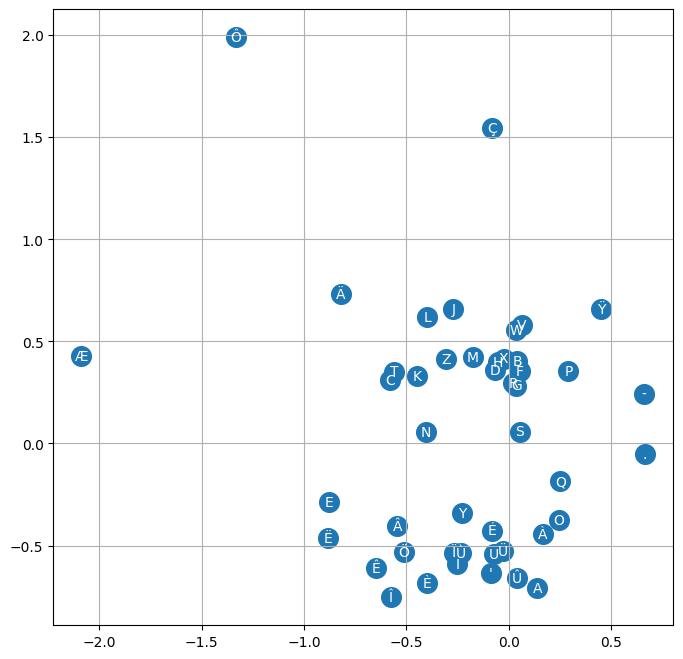

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

我们观察到一种趋势，即元音和辅音（在名字中经常可以互换）会聚集在一起。罕见字符（如 'ç'、'ö'、'ë'）的嵌入向量是不同的。此外，我们还注意到 '.' 和 '-' 之间的接近性，这在法语复合名字中是合理的。
这表明矩阵 $C$ 已经学会了根据字符的语义相似性进行某种*映射*。
